# 📈 Stock Price Forecasting using ARIMA, XGBoost, and Prophet

In this project, we perform time series forecasting of stock VWAP prices using three different models:
- ARIMA
- XGBoost
- Prophet

Our objective is to evaluate and compare model performance for short-term (30-day) prediction.


## Importing the dependenices

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error,mean_absolute_error
from prophet import Prophet

## DATA COLLECTION 

In [2]:
df=pd.read_csv('BAJFINANCE.csv')

In [3]:
#printing first 5 rows
df.head()

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
0,2000-01-03,BAJAUTOFIN,EQ,46.95,49.45,50.75,46.5,50.75,50.75,50.05,7600,3.803800e+10,NaN,NaN,NaN
1,2000-01-04,BAJAUTOFIN,EQ,50.75,53.20,53.20,47.9,48.00,48.10,48.56,5000,2.428000e+10,NaN,NaN,NaN
2,2000-01-05,BAJAUTOFIN,EQ,48.10,46.55,47.40,44.6,44.60,44.60,45.47,3500,1.591450e+10,NaN,NaN,NaN
3,2000-01-06,BAJAUTOFIN,EQ,44.60,43.50,46.00,42.1,46.00,45.25,44.43,6200,2.754750e+10,NaN,NaN,NaN
4,2000-01-07,BAJAUTOFIN,EQ,45.25,48.00,48.00,42.0,42.90,42.90,44.44,3500,1.555550e+10,NaN,NaN,NaN


In [4]:
df.set_index('Date',inplace=True)

## Data Preprocessing / Cleaning

In [5]:
#Checking for no. of rows and columns
df.shape

(5070, 14)

In [6]:
#CHECKING FOR SOME INFORMATION
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5070 entries, 2000-01-03 to 2020-08-31
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Symbol              5070 non-null   object 
 1   Series              5070 non-null   object 
 2   Prev Close          5070 non-null   float64
 3   Open                5070 non-null   float64
 4   High                5070 non-null   float64
 5   Low                 5070 non-null   float64
 6   Last                5070 non-null   float64
 7   Close               5070 non-null   float64
 8   VWAP                5070 non-null   float64
 9   Volume              5070 non-null   int64  
 10  Turnover            5070 non-null   float64
 11  Trades              2291 non-null   float64
 12  Deliverable Volume  4624 non-null   float64
 13  %Deliverble         4624 non-null   float64
dtypes: float64(11), int64(1), object(2)
memory usage: 594.1+ KB


In [7]:
#checking for missing values
df.isnull().sum()

Symbol                   0
Series                   0
Prev Close               0
Open                     0
High                     0
Low                      0
Last                     0
Close                    0
VWAP                     0
Volume                   0
Turnover                 0
Trades                2779
Deliverable Volume     446
%Deliverble            446
dtype: int64

In [8]:
# Handling the missing values
df['Trades'].fillna(df['Trades'].median(), inplace=True)


In [9]:
df.isnull().sum()

Symbol                  0
Series                  0
Prev Close              0
Open                    0
High                    0
Low                     0
Last                    0
Close                   0
VWAP                    0
Volume                  0
Turnover                0
Trades                  0
Deliverable Volume    446
%Deliverble           446
dtype: int64

In [10]:
# Drop only rows where 'Deliverable Volume' or '%Deliverble' is missing
df.dropna(subset=['Deliverable Volume', '%Deliverble'], inplace=True)

In [11]:
df.shape

(4624, 14)

In [12]:
df.isnull().shape

(4624, 14)

In [13]:
#checking for dtypes
df.dtypes

Symbol                 object
Series                 object
Prev Close            float64
Open                  float64
High                  float64
Low                   float64
Last                  float64
Close                 float64
VWAP                  float64
Volume                  int64
Turnover              float64
Trades                float64
Deliverable Volume    float64
%Deliverble           float64
dtype: object

In [14]:
#checking for columns
df.columns

Index(['Symbol', 'Series', 'Prev Close', 'Open', 'High', 'Low', 'Last',
       'Close', 'VWAP', 'Volume', 'Turnover', 'Trades', 'Deliverable Volume',
       '%Deliverble'],
      dtype='object')

## EDA AND Feature Engineering

<Axes: xlabel='Date'>

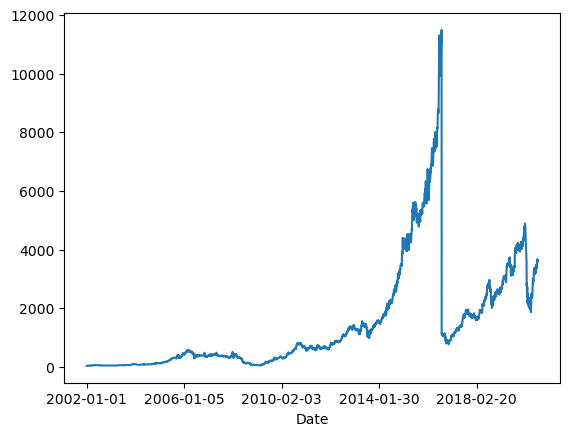

In [15]:
df['VWAP'].plot()

In [16]:
#Creating some lag features
lag_features=['High', 'Low','Volume', 'Turnover', 'Trades']
window1=3
window2=7

In [17]:
for feature in lag_features:
    df[feature+'rolling_mean_3']=df[feature].rolling(window=window1).mean()
    df[feature+'rolling_mean_7']=df[feature].rolling(window=window2).mean()

In [18]:
for feature in lag_features:
    df[feature+'rolling_std_3']=df[feature].rolling(window=window1).std()
    df[feature+'rolling_std_7']=df[feature].rolling(window=window2).std()

In [19]:
df.head()

,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,...,Highrolling_std_3,Highrolling_std_7,Lowrolling_std_3,Lowrolling_std_7,Volumerolling_std_3,Volumerolling_std_7,Turnoverrolling_std_3,Turnoverrolling_std_7,Tradesrolling_std_3,Tradesrolling_std_7
Date,,,,,,,,,,,,,,,,,,,,,
2002-01-01,BAJAUTOFIN,EQ,33.55,33.60,34.00,33.00,34.00,34.00,33.84,500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002-01-02,BAJAUTOFIN,EQ,34.00,34.85,34.85,33.85,34.20,34.20,33.97,1448,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002-01-03,BAJAUTOFIN,EQ,34.20,35.00,35.00,34.05,34.50,34.50,34.28,600,...,0.539290,NaN,0.557524,NaN,520.865946,NaN,1.767081e+09,NaN,0.0,NaN
2002-01-07,BAJAUTOFIN,EQ,34.50,34.05,35.00,34.05,34.25,34.25,34.24,145,...,0.086603,NaN,0.115470,NaN,661.304015,NaN,2.242757e+09,NaN,0.0,NaN
2002-01-08,BAJAUTOFIN,EQ,34.25,34.05,34.50,34.00,34.00,34.00,34.07,800,...,0.288675,NaN,0.028868,NaN,335.670970,NaN,1.143860e+09,NaN,0.0,NaN


In [20]:
df.shape

(4624, 34)

In [21]:
df.isnull().sum()

Symbol                    0
Series                    0
Prev Close                0
Open                      0
High                      0
Low                       0
Last                      0
Close                     0
VWAP                      0
Volume                    0
Turnover                  0
Trades                    0
Deliverable Volume        0
%Deliverble               0
Highrolling_mean_3        2
Highrolling_mean_7        6
Lowrolling_mean_3         2
Lowrolling_mean_7         6
Volumerolling_mean_3      2
Volumerolling_mean_7      6
Turnoverrolling_mean_3    2
Turnoverrolling_mean_7    6
Tradesrolling_mean_3      2
Tradesrolling_mean_7      6
Highrolling_std_3         2
Highrolling_std_7         6
Lowrolling_std_3          2
Lowrolling_std_7          6
Volumerolling_std_3       2
Volumerolling_std_7       6
Turnoverrolling_std_3     2
Turnoverrolling_std_7     6
Tradesrolling_std_3       2
Tradesrolling_std_7       6
dtype: int64

In [22]:
df.dropna(inplace=True)

In [23]:
df.columns

Index(['Symbol', 'Series', 'Prev Close', 'Open', 'High', 'Low', 'Last',
       'Close', 'VWAP', 'Volume', 'Turnover', 'Trades', 'Deliverable Volume',
       '%Deliverble', 'Highrolling_mean_3', 'Highrolling_mean_7',
       'Lowrolling_mean_3', 'Lowrolling_mean_7', 'Volumerolling_mean_3',
       'Volumerolling_mean_7', 'Turnoverrolling_mean_3',
       'Turnoverrolling_mean_7', 'Tradesrolling_mean_3',
       'Tradesrolling_mean_7', 'Highrolling_std_3', 'Highrolling_std_7',
       'Lowrolling_std_3', 'Lowrolling_std_7', 'Volumerolling_std_3',
       'Volumerolling_std_7', 'Turnoverrolling_std_3', 'Turnoverrolling_std_7',
       'Tradesrolling_std_3', 'Tradesrolling_std_7'],
      dtype='object')

**selecting the important columns**

In [24]:
ind_features=['Highrolling_mean_3', 'Highrolling_mean_7',
       'Lowrolling_mean_3', 'Lowrolling_mean_7', 'Volumerolling_mean_3',
       'Volumerolling_mean_7', 'Turnoverrolling_mean_3',
       'Turnoverrolling_mean_7', 'Tradesrolling_mean_3',
       'Tradesrolling_mean_7', 'Highrolling_std_3', 'Highrolling_std_7',
       'Lowrolling_std_3', 'Lowrolling_std_7', 'Volumerolling_std_3',
       'Volumerolling_std_7', 'Turnoverrolling_std_3', 'Turnoverrolling_std_7',
       'Tradesrolling_std_3', 'Tradesrolling_std_7']

## Train/Test split

In [25]:
train_data=df[:-30]
test_data=df[-30:]

In [26]:
df.shape

(4618, 34)

In [27]:
import warnings
warnings.filterwarnings('ignore')

# Checking for stationarity

In [28]:
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [30]:
adf_test(train_data['VWAP'].diff())

Augmented Dickey-Fuller Test: 
ADF test statistic     -1.336175e+01
p-value                 5.410772e-25
# lags used             2.900000e+01
# observations          4.557000e+03
critical value (1%)    -3.431786e+00
critical value (5%)    -2.862174e+00
critical value (10%)   -2.567108e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


## PLotting ACF and PACF plot

Text(0.5, 1.0, 'PACF Plot of Differenced VWAP')

<Figure size 1000x500 with 0 Axes>

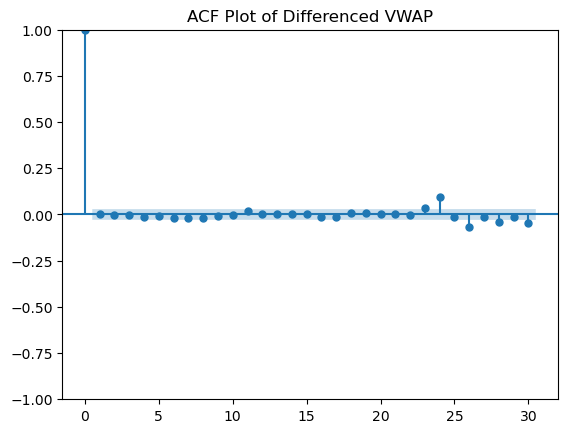

<Figure size 1000x500 with 0 Axes>

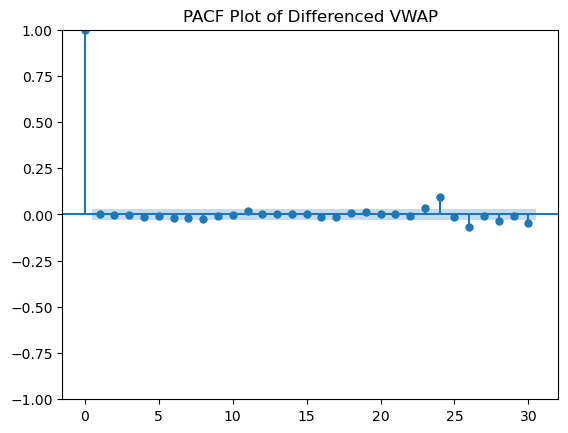

In [31]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
%matplotlib inline

# Use your differenced VWAP series (for stationarity)
series = train_data['VWAP'].diff().dropna()

# ACF Plot
plt.figure(figsize=(10, 5))
plot_acf(series, lags=30)
plt.title("ACF Plot of Differenced VWAP")


# PACF Plot
plt.figure(figsize=(10, 5))
plot_pacf(series, lags=30)
plt.title("PACF Plot of Differenced VWAP")

In [32]:
# Determining the best order for model
from pmdarima import auto_arima

In [33]:
#model training arima model

In [34]:
model=auto_arima(y=train_data['VWAP'],X=train_data[ind_features],trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=49851.762, Time=16.21 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=49868.690, Time=9.51 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=49860.353, Time=9.99 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=49859.913, Time=12.55 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=83962.035, Time=8.86 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=49852.967, Time=14.98 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=49874.842, Time=14.33 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=49833.906, Time=16.50 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=49835.809, Time=15.23 sec
 ARIMA(4,0,2)(0,0,0)[0] intercept   : AIC=49881.048, Time=17.45 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=49827.467, Time=17.65 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=49830.734, Time=17.00 sec
 ARIMA(4,0,3)(0,0,0)[0] intercept   : AIC=49830.281, Time=17.96 sec
 ARIMA(3,0,4)(0,0,0)[0] intercept   : AIC=49827.027, Time=19.70 sec
 ARIMA(2

In [35]:
#fitting the model on training data
model.fit(train_data['VWAP'],train_data[ind_features])

,order,"(3, ...)"
,seasonal_order,"(0, ...)"
,start_params,None
,method,'lbfgs'
,maxiter,50
,suppress_warnings,True
,out_of_sample_size,0
,scoring,'mse'
,scoring_args,{}
,trend,None
,with_intercept,False


In [36]:
#forecast on test data
forecast=model.predict(n_periods=len(test_data),X=test_data[ind_features])

In [37]:
forecast

4588    3503.554305
4589    3477.899537
4590    3488.055716
4591    3374.226357
4592    3323.286115
4593    3307.187865
4594    3337.715490
4595    3285.387414
4596    3242.573918
4597    3242.782098
4598    3216.215619
4599    3206.374764
4600    3252.604965
4601    3385.260616
4602    3415.174460
4603    3474.473397
4604    3440.576024
4605    3408.678719
4606    3360.332643
4607    3352.408840
4608    3362.205789
4609    3350.597833
4610    3390.801259
4611    3400.972398
4612    3442.910747
4613    3563.065945
4614    3585.762960
4615    3685.327742
4616    3710.375496
4617    3656.106966
dtype: float64

In [38]:
test_data['VWAP']

Date
2020-07-21    3385.18
2020-07-22    3265.62
2020-07-23    3288.19
2020-07-24    3251.26
2020-07-27    3188.34
2020-07-28    3219.37
2020-07-29    3286.37
2020-07-30    3268.45
2020-07-31    3232.44
2020-08-03    3196.24
2020-08-04    3214.31
2020-08-05    3295.61
2020-08-06    3322.72
2020-08-07    3418.52
2020-08-10    3486.64
2020-08-11    3446.88
2020-08-12    3413.77
2020-08-13    3438.56
2020-08-14    3374.14
2020-08-17    3354.99
2020-08-18    3403.77
2020-08-19    3438.55
2020-08-20    3387.18
2020-08-21    3414.38
2020-08-24    3469.56
2020-08-25    3579.12
2020-08-26    3668.17
2020-08-27    3631.13
2020-08-28    3652.77
2020-08-31    3602.93
Name: VWAP, dtype: float64

In [39]:
#now adding forecast to test data
#step1: fully reset forecast index
forecast_reset=forecast.reset_index(drop=True)
#step2:now create a new series with test data datetimeindex
forecast_series=pd.Series(forecast_reset.values,index=test_data.index)

In [40]:
forecast_series

Date
2020-07-21    3503.554305
2020-07-22    3477.899537
2020-07-23    3488.055716
2020-07-24    3374.226357
2020-07-27    3323.286115
2020-07-28    3307.187865
2020-07-29    3337.715490
2020-07-30    3285.387414
2020-07-31    3242.573918
2020-08-03    3242.782098
2020-08-04    3216.215619
2020-08-05    3206.374764
2020-08-06    3252.604965
2020-08-07    3385.260616
2020-08-10    3415.174460
2020-08-11    3474.473397
2020-08-12    3440.576024
2020-08-13    3408.678719
2020-08-14    3360.332643
2020-08-17    3352.408840
2020-08-18    3362.205789
2020-08-19    3350.597833
2020-08-20    3390.801259
2020-08-21    3400.972398
2020-08-24    3442.910747
2020-08-25    3563.065945
2020-08-26    3585.762960
2020-08-27    3685.327742
2020-08-28    3710.375496
2020-08-31    3656.106966
dtype: float64

In [41]:
#Step 3: Assign
test_data['Forecast_ARIMA'] = forecast_series

# Step 4: Confirm
print(test_data[['VWAP', 'Forecast_ARIMA']].head())

               VWAP  Forecast_ARIMA
Date                               
2020-07-21  3385.18     3503.554305
2020-07-22  3265.62     3477.899537
2020-07-23  3288.19     3488.055716
2020-07-24  3251.26     3374.226357
2020-07-27  3188.34     3323.286115


## visualization for comparing values between real and predictive

<Axes: xlabel='Date'>

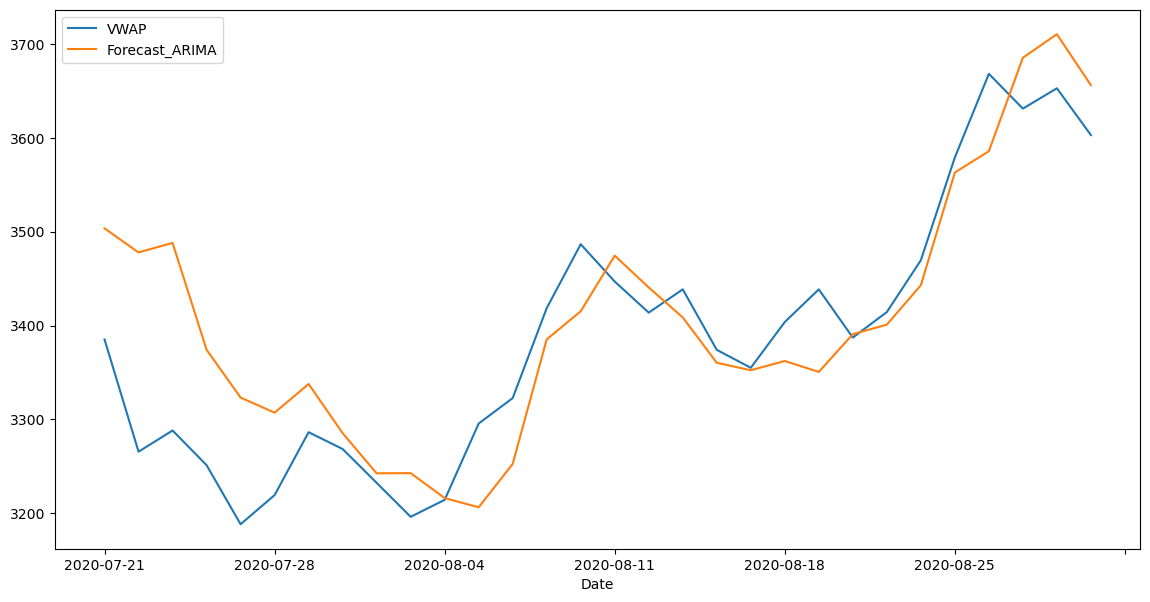

In [42]:
test_data[['VWAP','Forecast_ARIMA']].plot(figsize=(14,7))

<Axes: xlabel='Date'>

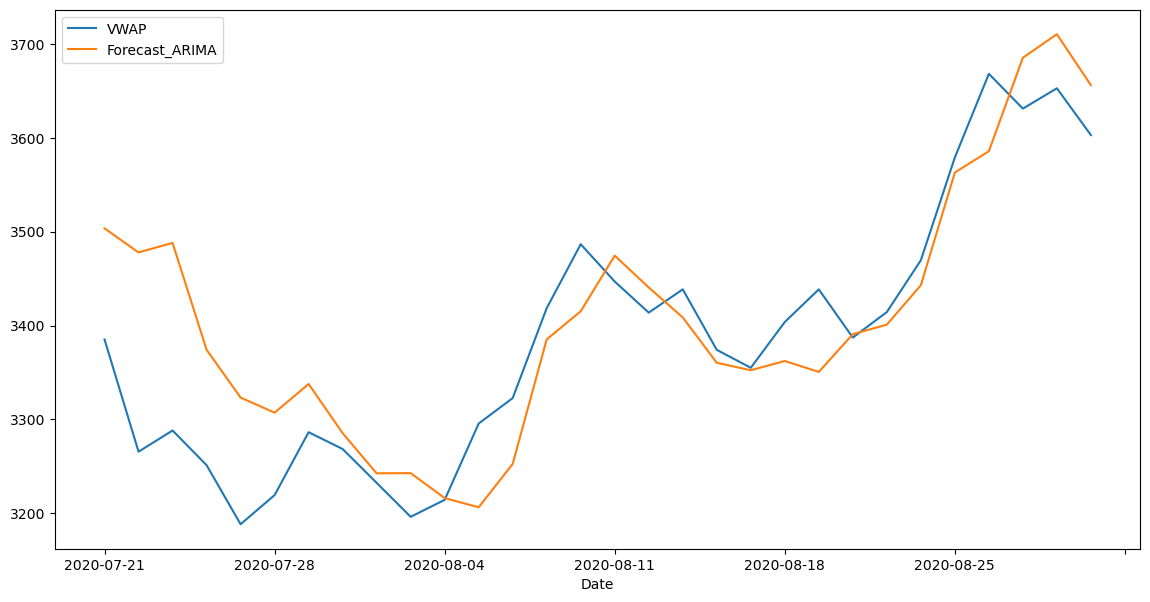

In [43]:
test_data[['VWAP','Forecast_ARIMA']].loc['2017-05-12':].plot(figsize=(14,7))

## MOdel Evaluation 

In [44]:
np.sqrt(mean_squared_error(test_data['VWAP'],test_data['Forecast_ARIMA']))

80.29558667593268

In [45]:
mean_absolute_error(test_data['VWAP'],test_data['Forecast_ARIMA'])

60.14982127866376

In [46]:
test_data['VWAP'].describe()

count      30.000000
mean     3386.505333
std       138.918286
min      3188.340000
25%      3272.930000
50%      3386.180000
75%      3444.800000
max      3668.170000
Name: VWAP, dtype: float64

<Axes: title={'center': 'Actual vs Predicted VWAP'}, xlabel='Date'>

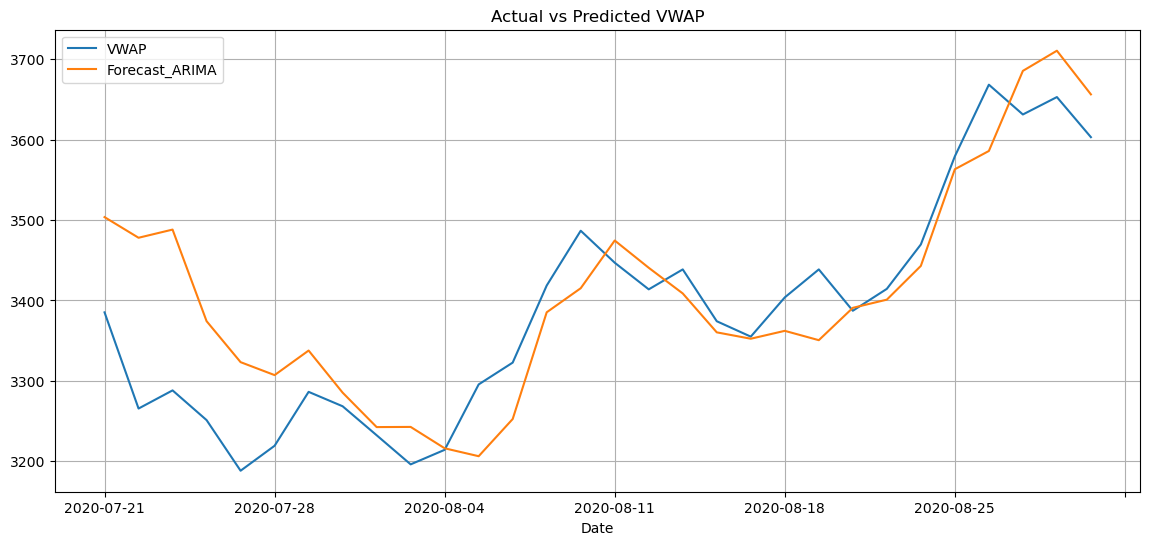

In [47]:
test_data[['VWAP', 'Forecast_ARIMA']].plot(figsize=(14,6), title='Actual vs Predicted VWAP', grid=True)


## Model training Xgboost 

In [48]:

from xgboost import XGBRegressor

X = df[ind_features]
y = df['VWAP']


X_train = X[:-30]  # All rows except last 30
X_test = X[-30:]   # Last 30 rows

y_train = y[:-30]
y_test = y[-30:]

In [49]:
model_xgb = XGBRegressor(random_state=42)
model_xgb.fit(X_train, y_train)

preds_xgb = model_xgb.predict(X_test)


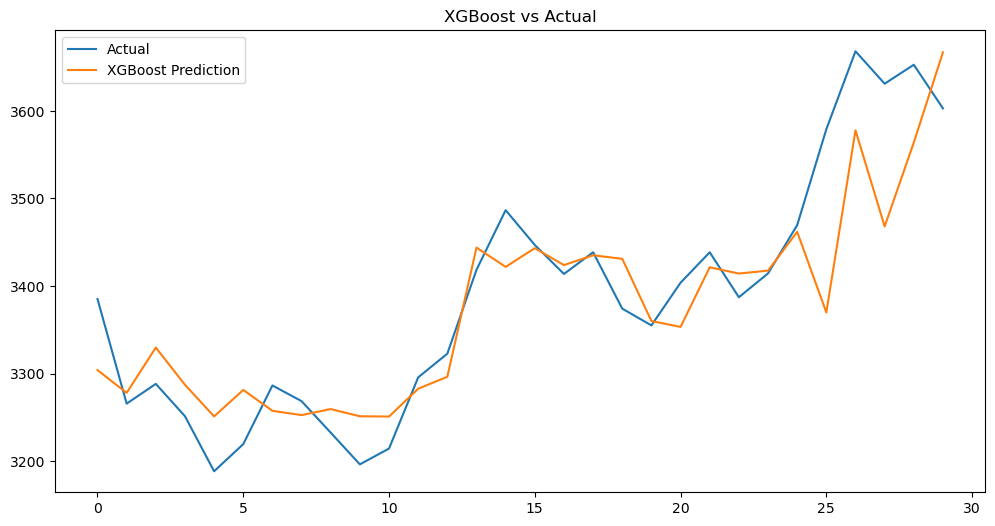

In [50]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.plot(y_test.values, label='Actual')
plt.plot(preds_xgb, label='XGBoost Prediction', linestyle='-')
plt.legend()
plt.title("XGBoost vs Actual")
plt.show()


## Feature Creating in test_data for better compairson acc. to date

In [51]:
# Create test_data only from the actual test set
test_data = X_test.copy()
test_data['VWAP'] = y_test
test_data['Forecast_XGBoost'] = preds_xgb


<Axes: title={'center': 'Actual vs XGBoost Prediction'}, xlabel='Date'>

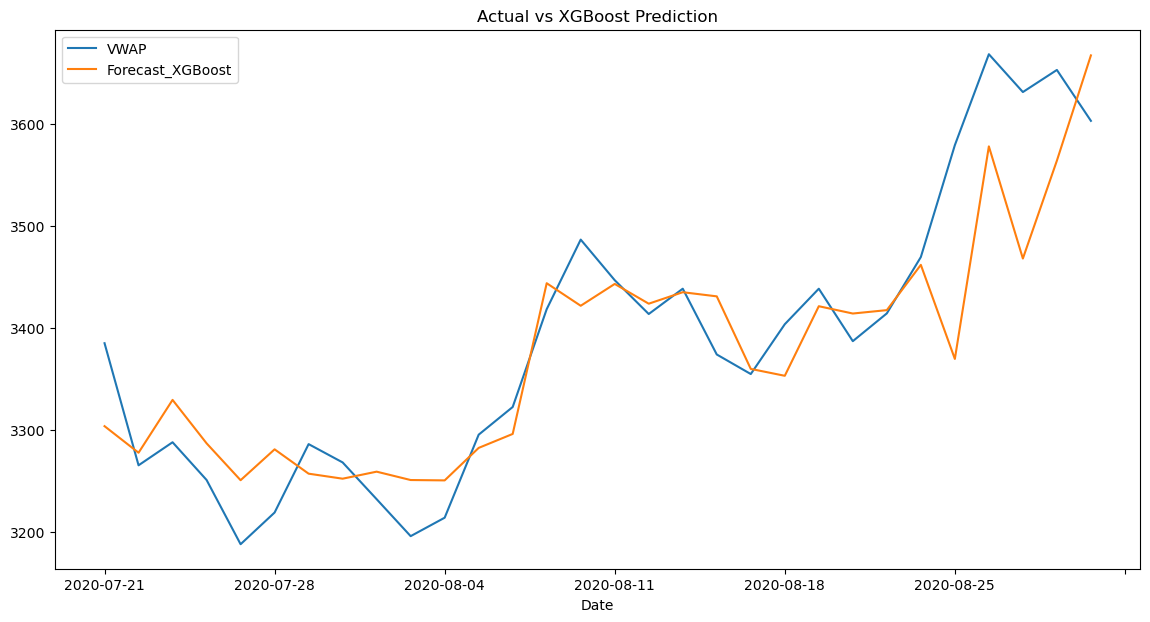

In [52]:
test_data[['VWAP', 'Forecast_XGBoost']].loc['2017-05-12':].plot(figsize=(14,7), title='Actual vs XGBoost Prediction')


## Model Evaluation

In [53]:
mae = mean_absolute_error(test_data['VWAP'], test_data['Forecast_XGBoost'])
rmse = np.sqrt(mean_squared_error(test_data['VWAP'], test_data['Forecast_XGBoost']))

print("MAE:", mae)
print("RMSE:", rmse)

MAE: 46.28565917968751
RMSE: 65.05817878941049


**Xgboost fit best for the data than ARIMA**

## Model  TRAINING WITH PROPHET

## Prepare Data for Prophet

In [54]:
df_prophet=df[['VWAP']].copy()
df_prophet=df_prophet.reset_index().rename(columns={'Date':'ds','VWAP':'y'})


**SPlit data: train=all but last 30 ,test=last 30**

In [55]:
train_prophet = df_prophet.iloc[:-30]
test_prophet = df_prophet.iloc[-30:]

In [56]:
# Initialize and fit Prophet
model_prophet = Prophet()
model_prophet.fit(train_prophet)


21:31:33 - cmdstanpy - INFO - Chain [1] start processing
21:31:35 - cmdstanpy - INFO - Chain [1] done processing


In [57]:
# Make future dataframe
future = model_prophet.make_future_dataframe(periods=30)
forecast = model_prophet.predict(future)

In [58]:
# Extract only the next 30 predicted days
forecast_30 = forecast[['ds', 'yhat']].tail(30).set_index('ds')
test_prophet = test_prophet.set_index('ds')

## EVALUATION


In [59]:
mae = mean_absolute_error(test_prophet['y'], forecast_30['yhat'])
rmse = np.sqrt(mean_squared_error(test_prophet['y'], forecast_30['yhat']))

print("Prophet MAE:", mae)
print("Prophet RMSE:", rmse)

Prophet MAE: 354.2385093121349
Prophet RMSE: 373.3578551737915


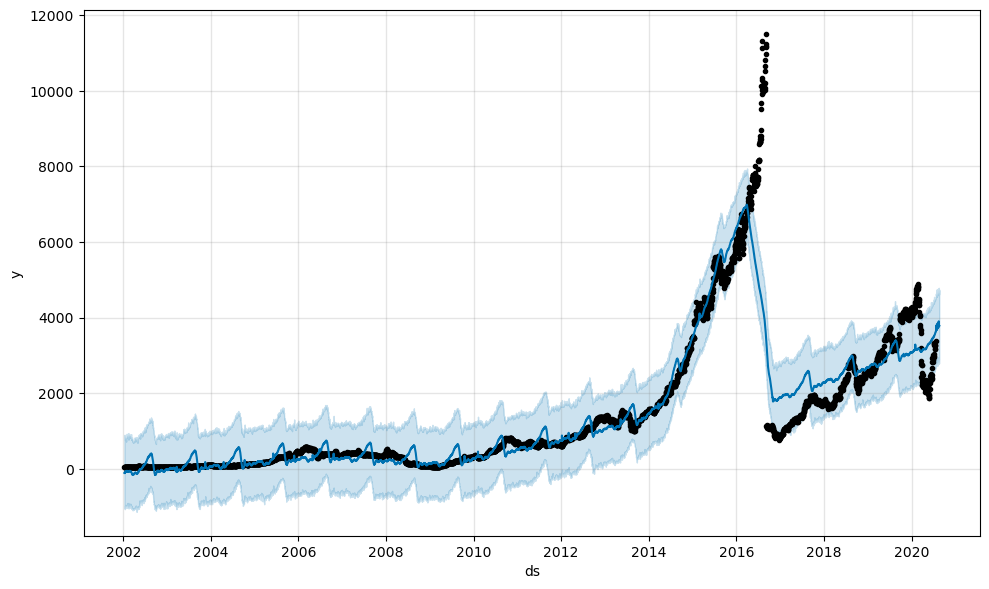

In [60]:
model_prophet.plot(forecast);


**prophet not work well for high volatility but xgboost work well as it not assume smoothness often does better for volatile stock data**

# 📈 Model Comparison
Use a table like:
| Model   | MAE    | RMSE   |
| ------- | ------ | ------ |
| ARIMA   | 60.15  | 80.30  |
| XGBoost | 46.29  | 65.06  |
| Prophet | 354.23 | 373.36 |


**Among all models tested, XGBoost outperformed both ARIMA and Prophet in terms of lower MAE and RMSE.**


### 📌 Conclusion

- **ARIMA** captured short-term trends moderately well but had some volatility.
- **XGBoost** gave the best performance based on MAE and RMSE.
- **Prophet** was useful for handling trends but showed higher error.

Overall, **XGBoost was the most accurate model** for forecasting the next 30 days of VWAP prices for Bajaj Finance.

This project demonstrates the practical application of time series forecasting using classical and machine learning methods.
